In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
#import libraries for model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import InputLayer, Input, BatchNormalization, AveragePooling2D, Dense, Conv2D , Flatten ,DepthwiseConv2D, ReLU ,GlobalAveragePooling2D , Dropout , MaxPool2D , Add 
import keras_tuner
from tensorflow import keras
from keras.models import Model , Sequential
from keras.applications.mobilenet import MobileNet
from keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
#import libraries for preproccessing
import dlib
from PIL import Image
from PIL import ImageFilter
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import os
import gc

# # Preprocessing Functions

In [4]:
def ReSize(image, size):
    resizedimg=cv2.resize(image,(size,size))
    return resizedimg 

def normalize(resimg):
    img=cv2.cvtColor(resimg,cv2.COLOR_BGR2RGB)
    img_normalized = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img1=cv2.cvtColor(img_normalized,cv2.COLOR_BGR2RGB)
    return img1    

def gray(normimg):
    img=cv2.cvtColor(normimg, cv2.COLOR_BGR2GRAY)
    grey=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return grey

def Brightnessandcontrast(normimg):
    Bright = 20
    Contrast = 1
    img=cv2.cvtColor(normimg,cv2.COLOR_BGR2RGB)
    adjusted = cv2.convertScaleAbs(img, alpha=Contrast, beta=Bright)
    rgbadjusted=cv2.cvtColor(adjusted,cv2.COLOR_BGR2RGB)
    return rgbadjusted

def mean_noise_reduction(normimg):
    img=cv2.cvtColor(normimg,cv2.COLOR_BGR2RGB)
    filteredimg = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    rgbfilteredimg=cv2.cvtColor(filteredimg,cv2.COLOR_BGR2RGB)
    return rgbfilteredimg

def three_noise_reduction(normimg):
    img=cv2.cvtColor(normimg,cv2.COLOR_BGR2RGB)
    filteredimg =cv2.GaussianBlur(img,(5,5),0)
    #filteredimg=cv2.blur(img,(5,5))
    #filteredimg=cv2.medianBlur(img,5)
    rgbfilteredimg=cv2.cvtColor(filteredimg,cv2.COLOR_BGR2RGB)
    return rgbfilteredimg

def face_detection(samdata):
    detector = dlib.cnn_face_detection_model_v1("/kaggle/input/models/mmod_human_face_detector (1)_1.dat")
    greyimg=cv2.cvtColor(samdata, cv2.COLOR_BGR2GRAY)
    detectedimg = detector(greyimg)
    
    for face in detectedimg:
        x1 = face.rect.left()
        y1 = face.rect.top()
        x2 = face.rect.right()
        y2 = face.rect.bottom()
        img=cv2.rectangle(samdata, (x1, y1), (x2, y2), (0, 0, 0), 2)
        img_height, img_width, c = img.shape
        samdata = img[max(0, face.rect.top()): min(face.rect.bottom(), img_height),max(0, face.rect.left()): min(face.rect.right(), img_width)]
        samdata =cv2.cvtColor(samdata,cv2.COLOR_BGR2RGB)
    return samdata

# # Load Dataset

In [5]:
train_autistic = "/kaggle/input/autistic-children-facial-data-set/train/autistic/"
train_nonAutistic = "/kaggle/input/autistic-children-facial-data-set/train/non_autistic/"

valid_autistic= "/kaggle/input/autistic-children-facial-data-set/valid/autistic/"
valid_nonAutistic= "/kaggle/input/autistic-children-facial-data-set/valid/non_autistic/"

test_autistic = "/kaggle/input/autistic-children-facial-data-set/test/autistic/"
test_nonAutistic = "/kaggle/input/autistic-children-facial-data-set/test/non_autistic/"

# # Encoding Dataset

In [6]:
def preprocessing_func(filename):
    x = []
    for file in os.listdir(filename):
        img  = cv2.imread(filename + file)
        img = face_detection(img)
        #img = ReSize(img, photo_size)
        #img = gray(img)
        #img = Brightnessandcontrast(img)
        #img = mean_noise_reduction(img)
        #img = normalize(img)
        plt.imshow(img)
        x.append(img)
    return x

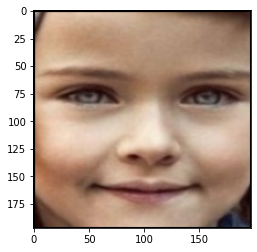

In [7]:
photo_size = 224
train_a= preprocessing_func(train_autistic)
train_n= preprocessing_func(train_nonAutistic)
valid_a= preprocessing_func(valid_autistic)
valid_n= preprocessing_func(valid_nonAutistic)
test_a=preprocessing_func(test_autistic)
test_n=preprocessing_func(test_nonAutistic)

In [8]:
from pathlib import Path
from keras.preprocessing.image import array_to_img
def createDirectory(directory_path , data_path , image_list):
    newpath =directory_path
    path = Path(newpath)
    if path.is_dir() == False:
        os.makedirs(newpath)
    i=0
    for imgpath in os.listdir(data_path):
        img = array_to_img(image_list[i])
        imgpath=imgpath.split("/")[-1]
        cv2.imwrite (directory_path+"/" + imgpath ,image_list[i])
        i=i+1

In [9]:
createDirectory(r'/kaggle/working/autistic-children-facial-data-set/train/autistic',train_autistic,train_a)
createDirectory(r'/kaggle/working/autistic-children-facial-data-set/train/non_autistic',train_nonAutistic,train_n)
createDirectory(r'/kaggle/working/autistic-children-facial-data-set/valid/autistic',valid_autistic,valid_a)
createDirectory(r'/kaggle/working/autistic-children-facial-data-set/valid/non_autistic',valid_nonAutistic,valid_n)
createDirectory(r'/kaggle/working/autistic-children-facial-data-set/test/autistic',test_autistic,test_a)
createDirectory(r'/kaggle/working/autistic-children-facial-data-set/test/non_autistic',test_nonAutistic,test_n)

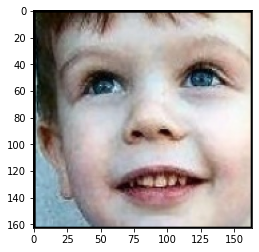

In [10]:
plt.imshow(train_a[0])

In [11]:
del train_autistic , train_nonAutistic , valid_autistic, valid_nonAutistic, test_autistic, test_nonAutistic, train_a , train_n , valid_a , valid_n , test_n , test_a
gc.collect()

243639

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(
    rescale=1./255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
valid_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)

traindata = train_data.flow_from_directory('/kaggle/input/autistic-children-facial-data-set/train',target_size=(photo_size,photo_size),batch_size=32,class_mode='binary', classes=['non_autistic','autistic'] )
testdata= test_data.flow_from_directory('/kaggle/input/autistic-children-facial-data-set/test', target_size=(photo_size,photo_size),batch_size=32,class_mode='binary',classes=['non_autistic','autistic'] )
validData = valid_data.flow_from_directory ('/kaggle/input/autistic-children-facial-data-set/valid', target_size=(photo_size,photo_size),batch_size=32,class_mode='binary',classes=['non_autistic','autistic'] )

Found 2536 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [13]:
"""img , label= traindata.next()
print(img.shape)
print(img.round())
plt.imshow(img[3])"""

'img , label= traindata.next()\nprint(img.shape)\nprint(img.round())\nplt.imshow(img[3])'

In [14]:
traindata.class_indices

{'non_autistic': 0, 'autistic': 1}

In [15]:
"""def read_data(list, photo_size):  
    data = []
    for i in range(len(list)):
        for filename in os.listdir(list[i]):
            img  = cv2.imread(list[i] + filename)
            img = face_detection(img)
            #img = gray(img)
            #img = Brightnessandcontrast(img)
            #img = mean_noise_reduction(img)
            #img = three_noise_reduction(img)
            img = ReSize(img, photo_size)
            img = normalize(img)
            data.append([img,i%2])
        
    
    random.shuffle(data)
    x = []
    y = []
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(data[i][1])
    
    x = np.array(x)
    y = np.array(y)
    return x , y"""

'def read_data(list, photo_size):  \n    data = []\n    for i in range(len(list)):\n        for filename in os.listdir(list[i]):\n            img  = cv2.imread(list[i] + filename)\n            img = face_detection(img)\n            #img = gray(img)\n            #img = Brightnessandcontrast(img)\n            #img = mean_noise_reduction(img)\n            #img = three_noise_reduction(img)\n            img = ReSize(img, photo_size)\n            img = normalize(img)\n            data.append([img,i%2])\n        \n    \n    random.shuffle(data)\n    x = []\n    y = []\n    for i in range(len(data)):\n        x.append(data[i][0])\n        y.append(data[i][1])\n    \n    x = np.array(x)\n    y = np.array(y)\n    return x , y'

In [16]:
"""ta = "/kaggle/input/autistic-children-facial-data-set/train/autistic/"
tn = "/kaggle/input/autistic-children-facial-data-set/train/non_autistic/"
testa = "/kaggle/input/autistic-children-facial-data-set/test/autistic/"
testn = "/kaggle/input/autistic-children-facial-data-set/test/non_autistic/"
va = "/kaggle/input/autistic-children-facial-data-set/valid/autistic/"
vn = "/kaggle/input/autistic-children-facial-data-set/valid/non_autistic/"

lis = [tn, ta , testn, testa, vn, va]


x, y = read_data(lis , 224)

del ta , tn , testa, testn, va, vn, lis

gc.collect()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.85, test_size = 0.15, stratify = y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size = 0.9, test_size = 0.1, stratify = y_train)
del x, y
gc.collect()"""

'ta = "/kaggle/input/autistic-children-facial-data-set/train/autistic/"\ntn = "/kaggle/input/autistic-children-facial-data-set/train/non_autistic/"\ntesta = "/kaggle/input/autistic-children-facial-data-set/test/autistic/"\ntestn = "/kaggle/input/autistic-children-facial-data-set/test/non_autistic/"\nva = "/kaggle/input/autistic-children-facial-data-set/valid/autistic/"\nvn = "/kaggle/input/autistic-children-facial-data-set/valid/non_autistic/"\n\nlis = [tn, ta , testn, testa, vn, va]\n\n\nx, y = read_data(lis , 224)\n\ndel ta , tn , testa, testn, va, vn, lis\n\ngc.collect()\nx_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.85, test_size = 0.15, stratify = y)\nx_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size = 0.9, test_size = 0.1, stratify = y_train)\ndel x, y\ngc.collect()'

# Load Dataset

In [17]:
"""train_data = "/kaggle/input/autism-image-data/AutismDataset/train"
test_data= "/kaggle/input/autism-image-data/AutismDataset/test"
valid_data_autistic = "/kaggle/input/autism-image-data/AutismDataset/valid/Autistic"
valid_data_nonautistic = "/kaggle/input/autism-image-data/AutismDataset/valid/Non_Autistic" """

'train_data = "/kaggle/input/autism-image-data/AutismDataset/train"\ntest_data= "/kaggle/input/autism-image-data/AutismDataset/test"\nvalid_data_autistic = "/kaggle/input/autism-image-data/AutismDataset/valid/Autistic"\nvalid_data_nonautistic = "/kaggle/input/autism-image-data/AutismDataset/valid/Non_Autistic" '

In [18]:
"""train_img = ["/kaggle/input/autism-image-data/AutismDataset/train/{}".format(i) for i in os.listdir(train_data)]

test_img = ["/kaggle/input/autism-image-data/AutismDataset/test/{}".format(i) for i in os.listdir(test_data)]

valid_autistic_img = ["/kaggle/input/autism-image-data/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(valid_data_autistic)]
valid_nonautistic_img = ["/kaggle/input/autism-image-data/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(valid_data_nonautistic)] """

'train_img = ["/kaggle/input/autism-image-data/AutismDataset/train/{}".format(i) for i in os.listdir(train_data)]\n\ntest_img = ["/kaggle/input/autism-image-data/AutismDataset/test/{}".format(i) for i in os.listdir(test_data)]\n\nvalid_autistic_img = ["/kaggle/input/autism-image-data/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(valid_data_autistic)]\nvalid_nonautistic_img = ["/kaggle/input/autism-image-data/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(valid_data_nonautistic)] '

In [19]:
"""from pathlib import Path
def insert_str(string, str_to_insert, index):
    return string[:index] + str_to_insert + string[index:]

newpath = r'/kaggle/working/autism-image-data/AutismDataset/valid'
path = Path(newpath)
if path.is_dir() == False:
    os.makedirs(newpath)
for i in range(len(valid_autistic_img)):
    image = cv2.imread(valid_autistic_img[i])
    valid_autistic_img[i]=valid_autistic_img[i].replace('/Autistic','')
    valid_autistic_img[i]= insert_str(valid_autistic_img[i],"Autistic.",52)
    valid_autistic_img[i]= valid_autistic_img[i].split("/")[-1]
    cv2.imwrite ("/kaggle/working/autism-image-data/AutismDataset/valid/"+valid_autistic_img[i],image)
for i in range(len(valid_nonautistic_img)):
    image = cv2.imread(valid_nonautistic_img[i])
    valid_nonautistic_img[i]=valid_nonautistic_img[i].replace('/Non_Autistic','')
    valid_nonautistic_img[i]= insert_str(valid_nonautistic_img[i],"Non_Autistic.",52)
    valid_nonautistic_img[i]= valid_nonautistic_img[i].split("/")[-1]
    cv2.imwrite ("/kaggle/working/autism-image-data/AutismDataset/valid/"+valid_nonautistic_img[i],image)"""

'from pathlib import Path\ndef insert_str(string, str_to_insert, index):\n    return string[:index] + str_to_insert + string[index:]\n\nnewpath = r\'/kaggle/working/autism-image-data/AutismDataset/valid\'\npath = Path(newpath)\nif path.is_dir() == False:\n    os.makedirs(newpath)\nfor i in range(len(valid_autistic_img)):\n    image = cv2.imread(valid_autistic_img[i])\n    valid_autistic_img[i]=valid_autistic_img[i].replace(\'/Autistic\',\'\')\n    valid_autistic_img[i]= insert_str(valid_autistic_img[i],"Autistic.",52)\n    valid_autistic_img[i]= valid_autistic_img[i].split("/")[-1]\n    cv2.imwrite ("/kaggle/working/autism-image-data/AutismDataset/valid/"+valid_autistic_img[i],image)\nfor i in range(len(valid_nonautistic_img)):\n    image = cv2.imread(valid_nonautistic_img[i])\n    valid_nonautistic_img[i]=valid_nonautistic_img[i].replace(\'/Non_Autistic\',\'\')\n    valid_nonautistic_img[i]= insert_str(valid_nonautistic_img[i],"Non_Autistic.",52)\n    valid_nonautistic_img[i]= valid_n

In [20]:
"""valid_img = ["/kaggle/working/autism-image-data/AutismDataset/valid/{}".format(i) for i in os.listdir("/kaggle/working/autism-image-data/AutismDataset/valid")]"""

'valid_img = ["/kaggle/working/autism-image-data/AutismDataset/valid/{}".format(i) for i in os.listdir("/kaggle/working/autism-image-data/AutismDataset/valid")]'

In [21]:
"""def encode_data (imagePath):
    x = []
    y = []
    for img_path in imagePath:
        img= img_path.split("/")[-1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if 'Autistic' in img:
            x.append(image)
            y.append(0)
        if 'Non_Autistic' in img:
            x.append(image)
            y.append(1)
    return x , y"""

'def encode_data (imagePath):\n    x = []\n    y = []\n    for img_path in imagePath:\n        img= img_path.split("/")[-1]\n        image = cv2.imread(img_path)\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n        if \'Autistic\' in img:\n            x.append(image)\n            y.append(0)\n        if \'Non_Autistic\' in img:\n            x.append(image)\n            y.append(1)\n    return x , y'

In [22]:
"""x_train , y_train = encode_data(train_img)
x_test , y_test = encode_data(test_img)
x_valid , y_valid = encode_data(valid_img)"""

'x_train , y_train = encode_data(train_img)\nx_test , y_test = encode_data(test_img)\nx_valid , y_valid = encode_data(valid_img)'

In [23]:
"""print(y_train)"""

'print(y_train)'

# Preprocessing

In [24]:
"""def cropping_based_face_detection(samdata):
    detector = dlib.cnn_face_detection_model_v1("/kaggle/input/models/mmod_human_face_detector (1)_1.dat")
    greyimg=cv2.cvtColor(samdata, cv2.COLOR_BGR2GRAY)
    detectedimg = detector(greyimg)
    
    for face in detectedimg:
        x1 = face.rect.left()
        y1 = face.rect.top()
        x2 = face.rect.right()
        y2 = face.rect.bottom()
        img=cv2.rectangle(samdata, (x1, y1), (x2, y2), (0, 0, 0), 2)
        img_height, img_width, c = img.shape
        cropped = img[max(0, face.rect.top()): min(face.rect.bottom(), img_height),max(0, face.rect.left()): min(face.rect.right(), img_width)]
    return cropped   
for i in range(len(x_train)):
    x_train[i]=cropping_based_face_detection(x_train[i])
for i in range(len(x_valid)):
    x_valid[i]=cropping_based_face_detection(x_valid[i])
for i in range(len(x_test)):
    x_test[i]=cropping_based_face_detection(x_test[i])"""

'def cropping_based_face_detection(samdata):\n    detector = dlib.cnn_face_detection_model_v1("/kaggle/input/models/mmod_human_face_detector (1)_1.dat")\n    greyimg=cv2.cvtColor(samdata, cv2.COLOR_BGR2GRAY)\n    detectedimg = detector(greyimg)\n    \n    for face in detectedimg:\n        x1 = face.rect.left()\n        y1 = face.rect.top()\n        x2 = face.rect.right()\n        y2 = face.rect.bottom()\n        img=cv2.rectangle(samdata, (x1, y1), (x2, y2), (0, 0, 0), 2)\n        img_height, img_width, c = img.shape\n        cropped = img[max(0, face.rect.top()): min(face.rect.bottom(), img_height),max(0, face.rect.left()): min(face.rect.right(), img_width)]\n    return cropped   \nfor i in range(len(x_train)):\n    x_train[i]=cropping_based_face_detection(x_train[i])\nfor i in range(len(x_valid)):\n    x_valid[i]=cropping_based_face_detection(x_valid[i])\nfor i in range(len(x_test)):\n    x_test[i]=cropping_based_face_detection(x_test[i])'

In [25]:
#print(x_train)

In [26]:
"""def ReSize(detimg):
    img=cv2.resize(detimg,(224,224))
    return img

for i in range(len(x_train)):
    x_train[i]=ReSize(x_train[i])
for i in range(len(x_valid)):
    x_valid[i]=ReSize(x_valid[i])
for i in range(len(x_test)):
    x_test[i]=ReSize(x_test[i])"""

'def ReSize(detimg):\n    img=cv2.resize(detimg,(224,224))\n    return img\n\nfor i in range(len(x_train)):\n    x_train[i]=ReSize(x_train[i])\nfor i in range(len(x_valid)):\n    x_valid[i]=ReSize(x_valid[i])\nfor i in range(len(x_test)):\n    x_test[i]=ReSize(x_test[i])'

In [27]:
"""def normalize(resimg):
    img=cv2.cvtColor(resimg,cv2.COLOR_BGR2RGB)
    img_normalized = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img_normalized=cv2.cvtColor(img_normalized,cv2.COLOR_BGR2RGB)
    return img_normalized

for i in range(len(x_train)):
    x_train[i]=normalize(x_train[i])
for i in range(len(x_valid)):
    x_valid[i]=normalize(x_valid[i])
for i in range(len(x_test)):
    x_test[i]=normalize(x_test[i])"""

'def normalize(resimg):\n    img=cv2.cvtColor(resimg,cv2.COLOR_BGR2RGB)\n    img_normalized = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)\n    img_normalized=cv2.cvtColor(img_normalized,cv2.COLOR_BGR2RGB)\n    return img_normalized\n\nfor i in range(len(x_train)):\n    x_train[i]=normalize(x_train[i])\nfor i in range(len(x_valid)):\n    x_valid[i]=normalize(x_valid[i])\nfor i in range(len(x_test)):\n    x_test[i]=normalize(x_test[i])'

In [28]:
"""x_train = np.array([np.array(val) for val in x_train])
y_train = np.array([np.array(val) for val in y_train])
x_valid = np.array([np.array(val) for val in x_valid])
y_valid = np.array([np.array(val) for val in y_valid])
x_test = np.array([np.array(val) for val in x_test])
y_test = np.array([np.array(val) for val in y_test])

x_test = tf.cast(x_test , dtype=tf.float32)
y_test = tf.cast(y_test , dtype=tf.float32)
x_train = tf.cast(x_train , dtype=tf.float32)
y_train = tf.cast(y_train , dtype=tf.float32)
x_valid = tf.cast(x_valid , dtype=tf.float32)
y_valid = tf.cast(y_valid , dtype=tf.float32)"""

'x_train = np.array([np.array(val) for val in x_train])\ny_train = np.array([np.array(val) for val in y_train])\nx_valid = np.array([np.array(val) for val in x_valid])\ny_valid = np.array([np.array(val) for val in y_valid])\nx_test = np.array([np.array(val) for val in x_test])\ny_test = np.array([np.array(val) for val in y_test])\n\nx_test = tf.cast(x_test , dtype=tf.float32)\ny_test = tf.cast(y_test , dtype=tf.float32)\nx_train = tf.cast(x_train , dtype=tf.float32)\ny_train = tf.cast(y_train , dtype=tf.float32)\nx_valid = tf.cast(x_valid , dtype=tf.float32)\ny_valid = tf.cast(y_valid , dtype=tf.float32)'

# pretrained mobileNetV1 Model

In [29]:
"""from tensorflow.keras.optimizers import RMSprop
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(224,224,3), weights='imagenet',include_top=False)
for layers in base_model.layers:
    layers.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model= Model(inputs = base_model.input, outputs = predictions)

from tensorflow.keras import layers

inputs = layers.Input(shape = (600,600,3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(1, name='outputLayer')(x)
outputs = layers.Activation(activation="sigmoid", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")

model.summary()"""

'from tensorflow.keras.optimizers import RMSprop\nbase_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(224,224,3), weights=\'imagenet\',include_top=False)\nfor layers in base_model.layers:\n    layers.trainable = False\n\nx = base_model.output\nx = Flatten()(x)\nx = Dense(256, activation="relu")(x)\nx = Dense(256, activation="relu")(x)\nx = Dropout(0.5)(x)\n\n# Add a final sigmoid layer with 1 node for classification output\npredictions = Dense(1, activation="sigmoid")(x)\nmodel= Model(inputs = base_model.input, outputs = predictions)\n\nfrom tensorflow.keras import layers\n\ninputs = layers.Input(shape = (600,600,3), name=\'inputLayer\')\nx = base_model(inputs, training = False)\nx = layers.GlobalAveragePooling2D(name=\'poolingLayer\')(x)\nx = layers.Dense(1, name=\'outputLayer\')(x)\noutputs = layers.Activation(activation="sigmoid", dtype=tf.float32, name=\'activationLayer\')(x)\n\nmodel = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")\n\nmode

In [30]:
#m_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), alpha=1, weights=None,classes=1)


In [31]:
"""def depth_block(x, strides):
    x = DepthwiseConv2D(3,strides=strides,padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
def single_conv_block(x,filters):
    x = Conv2D(filters, 1,use_bias=False)(x)
    x= BatchNormalization()(x)
    x = ReLU()(x)
    return x
def combo_layer(x,filters,strides):
    x = depth_block(x,strides)
    x = single_conv_block(x, filters)
    return x

from tensorflow.keras import regularizers

def build_model(hp):
    
    input_shape=(224,224,3)
    input =Input(input_shape)
    x = Conv2D(32,3,strides=(2,2),padding = 'same', use_bias=False) (input)
    x =  BatchNormalization()(x)
    x = ReLU()(x)
    x = combo_layer(x,64, strides=(1,1))
    x = combo_layer(x,128,strides=(2,2))
    x = combo_layer(x,128,strides=(1,1))
    x = combo_layer(x,256,strides=(2,2))
    x = combo_layer(x,256,strides=(1,1))
    x = combo_layer(x,512,strides=(2,2))
    for _ in range(5):
        x = combo_layer(x,512,strides=(1,1))
    x = combo_layer(x,1024,strides=(2,2))
    x = combo_layer(x,1024,strides=(1,1))
    
    # Hyperparameters
    #hp_dropout = hp.Float('dropout',0.4, 0.9, step=0.1)
    #n_classes = tf.keras.regularizers.L2(hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4]))
    hp_lr = hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    hp_regul= hp.Choice('l2',values=[1e-3,1e-4,1e-5])
    #hp_units = hp.Int('units',32,512, step=32)
    #x=Dropout(0.6)(x)
    x = GlobalAveragePooling2D()(x)
    x=BatchNormalization()(x)
    x=Dense(128 , kernel_regularizer=regularizers.l2(hp_regul))(x)
    x=BatchNormalization()(x)
    x=Dense(16 , kernel_regularizer=regularizers.l2(hp_regul))(x)
    x=BatchNormalization()(x)
    output = Dense(10,activation='softmax')(x)
    model = Model(input, output)
    model.compile( optimizer=Adam(learning_rate=hp_lr),loss = 'sparse_categorical_crossentropy',metrics=['acc'])

    
    return model"""

"def depth_block(x, strides):\n    x = DepthwiseConv2D(3,strides=strides,padding='same',  use_bias=False)(x)\n    x = BatchNormalization()(x)\n    x = ReLU()(x)\n    return x\ndef single_conv_block(x,filters):\n    x = Conv2D(filters, 1,use_bias=False)(x)\n    x= BatchNormalization()(x)\n    x = ReLU()(x)\n    return x\ndef combo_layer(x,filters,strides):\n    x = depth_block(x,strides)\n    x = single_conv_block(x, filters)\n    return x\n\nfrom tensorflow.keras import regularizers\n\ndef build_model(hp):\n    \n    input_shape=(224,224,3)\n    input =Input(input_shape)\n    x = Conv2D(32,3,strides=(2,2),padding = 'same', use_bias=False) (input)\n    x =  BatchNormalization()(x)\n    x = ReLU()(x)\n    x = combo_layer(x,64, strides=(1,1))\n    x = combo_layer(x,128,strides=(2,2))\n    x = combo_layer(x,128,strides=(1,1))\n    x = combo_layer(x,256,strides=(2,2))\n    x = combo_layer(x,256,strides=(1,1))\n    x = combo_layer(x,512,strides=(2,2))\n    for _ in range(5):\n        x = com

In [32]:
def cal_steps(num_images, batch_size):
    # calculates steps for generator
    steps = num_images // batch_size
    # adds 1 to the generator steps if the steps multiplied by
    # the batch size is less than the total training samples
    return  steps

In [33]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [34]:
def use_efficient_net( model_type='B0'):
    from tensorflow.keras.optimizers import RMSprop
    from keras.models import Model
    import efficientnet.tfkeras as efn
    if model_type=='B0':
        efn_model = efn.EfficientNetB0(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    else:
        efn_model = efn.EfficientNetB7(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    for layer in efn_model.layers:
        layer.trainable = False
    #
    x = efn_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    #hp_dropout = hp.Float('dropout',0.4, 0.9, step=0.1)
    x = Dropout(0.5)(x)
    # Add a final sigmoid layer with 1 node for classification output
    predictions = Dense(1, activation="sigmoid")(x)
    efficient_net = Model(efn_model.input,predictions)
    #hp_lr = hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    efficient_net.compile(RMSprop(learning_rate=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])
    return efficient_net
efficient_net=use_efficient_net('B0')
efficient_net.summary()

16818176/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_____________________________

In [35]:
checkpoint = ModelCheckpoint("/kaggle/working/efficient_net_B0_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False)
early = EarlyStopping(monitor='val_accuracy',patience=30, verbose=1, mode='auto') 
effb0_history =efficient_net.fit(traindata, validation_data= validData, validation_steps=cal_steps(validData.samples,32),epochs=100 ,steps_per_epoch=cal_steps(traindata.samples,32))

efficient_net.save("/kaggle/working/efficient_net_B0_model.h5")

Epoch 1/100
79/79 [==============================] - 39s 420ms/step - loss: 0.7204 - accuracy: 0.6330 - val_loss: 0.5322 - val_accuracy: 0.6667
Epoch 2/100
79/79 [==============================] - 32s 399ms/step - loss: 0.6114 - accuracy: 0.6825 - val_loss: 0.4996 - val_accuracy: 0.7396
Epoch 3/100
79/79 [==============================] - 31s 397ms/step - loss: 0.5885 - accuracy: 0.6957 - val_loss: 0.4541 - val_accuracy: 0.7812
Epoch 4/100
79/79 [==============================] - 31s 394ms/step - loss: 0.5420 - accuracy: 0.7356 - val_loss: 0.4855 - val_accuracy: 0.7708
Epoch 5/100
79/79 [==============================] - 32s 405ms/step - loss: 0.5651 - accuracy: 0.7252 - val_loss: 0.5056 - val_accuracy: 0.7396
Epoch 6/100
79/79 [==============================] - 32s 405ms/step - loss: 0.5538 - accuracy: 0.7300 - val_loss: 0.5204 - val_accuracy: 0.7708
Epoch 7/100
79/79 [==============================] - 32s 401ms/step - loss: 0.5393 - accuracy: 0.7388 - val_loss: 0.4660 - val_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [36]:
def VGG16_model ():
    model = Sequential()
    model.add(InputLayer(input_shape = (224, 224, 3)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization()),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=2, activation="softmax"))
    for layer_idx in range(len(model.layers)):
        if layer_idx not in [1,2,3,9,10,11,15,16,17,18,21,22,23,24]:
            model.layers[layer_idx].trainable = False


    model.compile(optimizer=Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    return model

In [37]:
vgg16_model = VGG16_model()
vgg16_model.summary()
vgg_history =vgg16_model.fit(traindata, validation_data= validData,epochs=100)
vgg16_model.save("/kaggle/working/vgg16.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)     5

In [38]:
vgg16_model.evaluate(traindata)
vgg16_model.evaluate(validData)
vgg16_model.evaluate(testdata)

10/10 [==============================] - 2s 245ms/step - loss: 0.4531 - accuracy: 0.8233


[0.45310238003730774, 0.8233333230018616]

In [39]:
"""model = build_model()
model.summary()"""

'model = build_model()\nmodel.summary()'

In [40]:
"""tuner =  keras_tuner.RandomSearch(
                       use_efficient_net,
                       objective = "val_accuracy", #optimize val acc
                       max_trials=5, 
                       executions_per_trial=2,
                       directory='/kaggle/working/', #Saving dir
                       project_name='efficientNet_hpTunning')
tuner.search_space_summary()"""

'tuner =  keras_tuner.RandomSearch(\n                       use_efficient_net,\n                       objective = "val_accuracy", #optimize val acc\n                       max_trials=5, \n                       executions_per_trial=2,\n                       directory=\'/kaggle/working/\', #Saving dir\n                       project_name=\'efficientNet_hpTunning\')\ntuner.search_space_summary()'

In [41]:
"""checkpoint = ModelCheckpoint("/kaggle/working/mobilenet_v1_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False)
early = EarlyStopping(monitor='val_accuracy',patience=15, verbose=1, mode='auto') 
tuner.search(traindata, validation_data = validData, epochs = 100,callbacks=[early,checkpoint])"""

'checkpoint = ModelCheckpoint("/kaggle/working/mobilenet_v1_model.h5", monitor=\'val_accuracy\', verbose=1, save_best_only=True, save_weights_only=False)\nearly = EarlyStopping(monitor=\'val_accuracy\',patience=15, verbose=1, mode=\'auto\') \ntuner.search(traindata, validation_data = validData, epochs = 100,callbacks=[early,checkpoint])'

# Fit and Compile Model

In [42]:
"""#model.compile(optimizer=Adam(learning_rate=0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['acc'])
#hist = model.fit(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 64),epochs=50 ,steps_per_epoch=cal_steps(len(x_train), 64),shuffle = True , batch_size = 64 , callbacks=[early , checkpoint])
checkpoint = ModelCheckpoint("/kaggle/working/mobilenet_v1_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False)
early = EarlyStopping(monitor='val_acc',patience=15, verbose=1, mode='auto')
mobile_hist=tuner.search(traindata, validation_data= validData, validation_steps=cal_steps(validData.samples,32),epochs=50 ,steps_per_epoch=cal_steps(traindata.samples,32),callbacks=[early,checkpoint])
#hist = model.fit(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 128),epochs=100 ,steps_per_epoch=cal_steps(len(x_train), 128), callbacks=[early , checkpoint])
#tuner.search(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 32),epochs=100 ,steps_per_epoch=cal_steps(len(x_train), 32) , batch_size=32, callbacks=[early , checkpoint] , shuffle= True)"""

'#model.compile(optimizer=Adam(learning_rate=0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[\'acc\'])\n#hist = model.fit(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 64),epochs=50 ,steps_per_epoch=cal_steps(len(x_train), 64),shuffle = True , batch_size = 64 , callbacks=[early , checkpoint])\ncheckpoint = ModelCheckpoint("/kaggle/working/mobilenet_v1_model.h5", monitor=\'val_acc\', verbose=1, save_best_only=True, save_weights_only=False)\nearly = EarlyStopping(monitor=\'val_acc\',patience=15, verbose=1, mode=\'auto\')\nmobile_hist=tuner.search(traindata, validation_data= validData, validation_steps=cal_steps(validData.samples,32),epochs=50 ,steps_per_epoch=cal_steps(traindata.samples,32),callbacks=[early,checkpoint])\n#hist = model.fit(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 128),epochs=100 ,steps_per_epoch=cal_steps(len(x_train), 128), callbacks=[early , checkpoint])\n#tune

In [43]:
#tuner.results_summary()

In [44]:
"""best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)"""

'best_hp = tuner.get_best_hyperparameters(1)[0]\nprint(best_hp.values)'

# Plotting History of Model

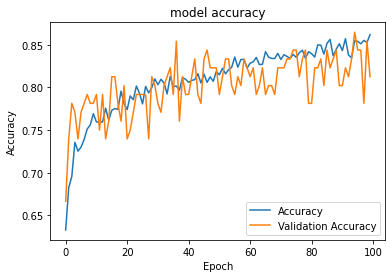

In [45]:
import matplotlib.pyplot as plt
plt.plot(effb0_history.history["accuracy"])
plt.plot(effb0_history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

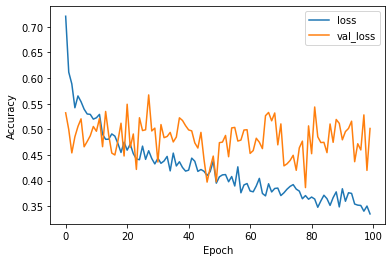

In [46]:
plt.plot(effb0_history.history['loss'])
plt.plot(effb0_history.history['val_loss'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["loss","val_loss"])
plt.show()

In [47]:
efficient_net.evaluate(traindata) 

80/80 [==============================] - 31s 385ms/step - loss: 0.3059 - accuracy: 0.8738


[0.30587825179100037, 0.8738170266151428]

In [48]:
efficient_net.evaluate(validData)

4/4 [==============================] - 0s 105ms/step - loss: 0.5074 - accuracy: 0.8100


[0.5074304342269897, 0.8100000023841858]

In [49]:
efficient_net.evaluate(testdata)

10/10 [==============================] - 1s 89ms/step - loss: 0.4469 - accuracy: 0.8400


[0.4469006359577179, 0.8399999737739563]

In [50]:
efficient_net.save("/kaggle/working/efficient_net_B0_model.h5")

Confusion Matrix
[[29 21]
 [28 22]]
Classification Report
              precision    recall  f1-score   support

non_autistic       0.51      0.58      0.54        50
    autistic       0.51      0.44      0.47        50

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.51      0.51      0.51       100



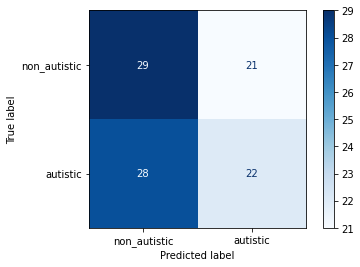

In [51]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix , classification_report

#Confution Matrix and Classification Report
Y_pred = efficient_net.predict(validData,cal_steps(validData.samples,32))
y_pred = Y_pred.round()
print('Confusion Matrix')
cm = confusion_matrix(validData.classes, y_pred)
print(cm)
print('Classification Report')
target_names = ['non_autistic','autistic']
print(classification_report(validData.classes, y_pred, target_names=target_names))
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [52]:
"""from tensorflow.keras.metrics import Accuracy
tf.keras.metrics.Accuracy(testdata.classes , y_pred)"""

'from tensorflow.keras.metrics import Accuracy\ntf.keras.metrics.Accuracy(testdata.classes , y_pred)'

In [53]:
"""datagen = ImageDataGenerator(rescale=1./255 ,  
                     rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2)

dir_It = datagen.flow_from_directory('/kaggle/input/datanew',target_size=(photo_size,photo_size),class_mode=None, classes=None )

img= dir_It.next()
print(img.shape)
print(img)"""

"datagen = ImageDataGenerator(rescale=1./255 ,  \n                     rotation_range=40,\n        width_shift_range=.2,\n        height_shift_range=.2,\n        shear_range=.1,\n        horizontal_flip=True,\n        fill_mode='nearest',\n        zoom_range=.2)\n\ndir_It = datagen.flow_from_directory('/kaggle/input/datanew',target_size=(photo_size,photo_size),class_mode=None, classes=None )\n\nimg= dir_It.next()\nprint(img.shape)\nprint(img)"

In [54]:
"""oData = '/kaggle/input/datanew/'
nData = '/kaggle/input/img-data/'
N = preprocessing_func(oData)
A = preprocessing_func(nData)
createDirectory(r'/kaggle/working/Data/omar/autistic',nData,A)
createDirectory(r'/kaggle/working/Data/omar/non_autistic',oData,N)"""

"oData = '/kaggle/input/datanew/'\nnData = '/kaggle/input/img-data/'\nN = preprocessing_func(oData)\nA = preprocessing_func(nData)\ncreateDirectory(r'/kaggle/working/Data/omar/autistic',nData,A)\ncreateDirectory(r'/kaggle/working/Data/omar/non_autistic',oData,N)"

In [55]:
"""l=cv2.imread('/kaggle/working/Data/omar/autistic/WhatsApp Image 2023-03-14 at 1.09.55 PM.jpeg')
plt.imshow(l)"""

"l=cv2.imread('/kaggle/working/Data/omar/autistic/WhatsApp Image 2023-03-14 at 1.09.55 PM.jpeg')\nplt.imshow(l)"

In [56]:
"""dirr= ImageDataGenerator(
        rescale=1./255,
    )
tr= dirr.flow_from_directory('/kaggle/working/Data/omar',target_size=(photo_size,photo_size))"""

"dirr= ImageDataGenerator(\n        rescale=1./255,\n    )\ntr= dirr.flow_from_directory('/kaggle/working/Data/omar',target_size=(photo_size,photo_size))"

In [57]:
"""img , label= tr.next()
print(img[0].shape)
#print(img[0])
print(type(img[0][0][0][0]))
plt.imshow(img[0])"""

'img , label= tr.next()\nprint(img[0].shape)\n#print(img[0])\nprint(type(img[0][0][0][0]))\nplt.imshow(img[0])'

In [58]:
img_path ="/kaggle/input/image-elshabab/WhatsApp Image 2023-03-26 at 11.54.57 AM.jpeg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#detected_img =face_detection(image)
resized_img = ReSize(image,224)
#img = three_noise_reduction(resized_img)
normalized_img = normalize(resized_img)
#plt.imshow(normalized_img)
normalized_img = np.array(normalized_img)
#print(normalized_img.shape)
#print(type(normalized_img[0][0][0]))
normalized_img = normalized_img.reshape(1,224,224,3)
prediction = efficient_net.predict(normalized_img).round()
print(prediction)

[[1.]]
